In [2]:
import pandas
import numpy

In [3]:
# Read the data
df = pandas.read_csv('sales_data.csv')
df.head()

,sales,date
0,112,2022-08-21
1,118,2022-08-22
2,132,2022-08-23
3,129,2022-08-24
4,121,2022-08-25


In [4]:
# date to datetime object
df['date'] = pandas.to_datetime(df['date'])

# date to index
df.set_index('date', inplace=True)


In [5]:
# general info about the data
df.info()

# check if there are any missing values
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 2022-08-21 to 2023-01-11
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   sales   144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


sales    0
dtype: int64

<AxesSubplot:xlabel='date'>

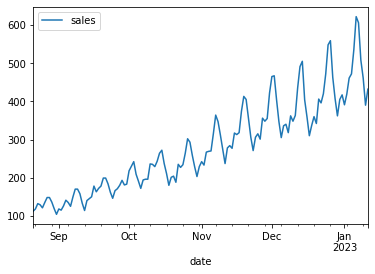

In [6]:
# plot the sales in a line chart
df.plot()

In [7]:
# create lagged features with 5 days lag
def create_lags():
    for i in range(1, 6):
        df['lag_' + str(i)] = df['sales'].shift(i)
    return df

df = create_lags()

In [8]:
# create rolling mean with 5, 10, 15, 20 days window
def create_rolling_mean():
    for i in [5, 10, 15, 20]:
        df['rolling_mean_' + str(i)] = df['sales'].shift().rolling(window=i).mean()
    return df

df = create_rolling_mean()

In [9]:
# drop all the missing values
df.dropna(inplace=True)

In [10]:
# split the data into train and test with in-built function
from sklearn.model_selection import train_test_split

X = df.drop('sales', axis=1)
y = df['sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [11]:
# Setup and Import data
from statsmodels.tsa.stattools import adfuller
import pandas as pd
import numpy as np
%matplotlib inline

# ADF Test
result = adfuller(df.sales, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'n_lags: {result[1]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')    

ADF Statistic: 0.672143608176639
n_lags: 0.9892652334489804
p-value: 0.9892652334489804
Critial Values:
   1%, -3.4912451337340342
Critial Values:
   5%, -2.8881954545454547
Critial Values:
   10%, -2.5809876033057852


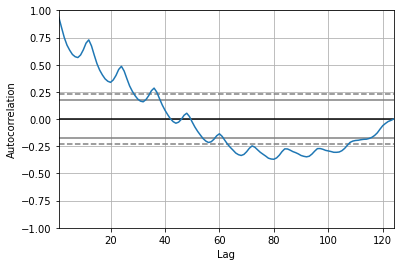

In [12]:
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df.sales)
pyplot.show()

In [13]:
p_values = [15,20,25,30,40]
d_values = range(0, 2)
q_values = [0,1,2,3,5,10,20]

In [14]:
# from statsmodels.tsa.arima.model import ARIMA
# from sklearn.metrics import mean_absolute_error
# from sklearn.model_selection import GridSearchCV
# import numpy as np
# import warnings
# 
# maes = {}
# for p in p_values:
#     for d in d_values:
#         for q in q_values:
#             order = (p,d,q)
#             model = ARIMA(y_train, exog=X_train, order=order).fit()
#             warnings.filterwarnings('ignore')
#             predictions = model.predict(start=len(y_train), end=len(y_train) + len(y_test)-1, exog=X_test)
#             error = mean_absolute_error(y_test, predictions)
#             print('ARIMA%s MAE=%.3f' % (order,error))
#             # store order and error in maes dictionary
#             maes[order] = error
# # print the best model with the least error from the maes dictionary
# print('Best ARIMA%s MAE=%.3f' % (min(maes, key=maes.get), maes[min(maes, key=maes.get)]))
# 
# # store the best order from maes in a variable
# best_order = min(maes, key=maes.get)

In [16]:
# import the ARIMA model
from statsmodels.tsa.arima.model import ARIMA

# create the model
model = ARIMA(y, exog=X, order=(20,0,10))

# fit the model
model_fit = model.fit()

# predict the sales
forecast = model_fit.get_forecast(steps=len(y), exog=X)
y_pred = forecast.predicted_mean
y_pred_conf_int = forecast.conf_int(alpha=0.05)

/home/olli/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/olli/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/olli/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/olli/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/olli/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible start

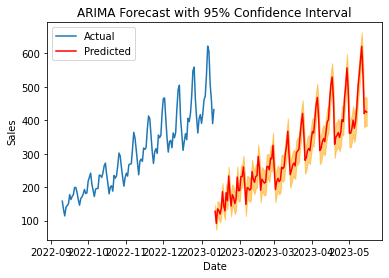

In [17]:
import matplotlib.pyplot as plt

# plot the actual data
plt.plot(df.sales, label='Actual')

# plot the predicted mean values
plt.plot(y_pred, label='Predicted', color='red')

# plot the lower and upper bounds of the confidence interval as shaded regions
plt.fill_between(y_pred_conf_int.index, y_pred_conf_int.iloc[:, 0], y_pred_conf_int.iloc[:, 1], color='orange', alpha=0.5)

# add labels, title and legend
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('ARIMA Forecast with 95% Confidence Interval')
plt.legend()

# show the plot
plt.show()


In [ ]:
from sklearn.feature_selection import SelectKBest, f_regression

# create the feature selection object
selector = SelectKBest(f_regression, k=5)

# fit the feature selection object to the lags or exogenous variables
selector.fit(X_train, y_train)

# select the top k lags or exogenous variables
X_top_k = selector.transform(X_train)

# create a list of the top k lags or exogenous variables
top_k = X_train.columns[selector.get_support()]

# print the top k lags or exogenous variables
print(top_k)

Index(['lag_1', 'rolling_mean_5', 'rolling_mean_10', 'rolling_mean_15',
       'rolling_mean_20'],
      dtype='object')


/home/olli/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/olli/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/olli/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/olli/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/olli/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible start

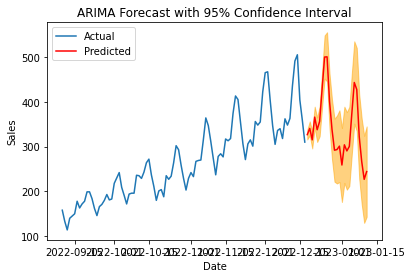

Mean Absolute Error: 105.495


In [ ]:
# import ARIMA
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# drop all the values except top_k
X_train = X_train[top_k]
X_test = X_test[top_k]

# create the model
model = ARIMA(y_train, exog=X_train, order=(30,1,20))

# fit the model
model_fit = model.fit()

# predict the sales
forecast = model_fit.get_forecast(steps=len(y_test), exog=X_test)

# get the predicted mean values
y_pred = forecast.predicted_mean

# get the confidence interval
y_pred_conf_int = forecast.conf_int(alpha=0.05)

# plot the actual data
plt.plot(y_train, label='Actual')

# plot the predicted mean values
plt.plot(y_pred, label='Predicted', color='red')

# plot the lower and upper bounds of the confidence interval as shaded regions
plt.fill_between(y_pred_conf_int.index, y_pred_conf_int.iloc[:, 0], y_pred_conf_int.iloc[:, 1], color='orange', alpha=0.5)

# add labels, title and legend
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('ARIMA Forecast with 95% Confidence Interval')
plt.legend()

# show the plot
plt.show()

from sklearn.metrics import mean_absolute_error

# calculate the mean absolute error
mae = mean_absolute_error(y_test, y_pred)

# print the mean absolute error
print('Mean Absolute Error: %.3f' % mae)

